In [19]:
# ========================
# Step 1. Mount Google Drive
# ========================
from google.colab import drive
import os

drive.mount('/content/drive')

# Project structure
proj_dir = "/content/drive/MyDrive/spatial-VROmics-analysis"
data_dir = os.path.join(proj_dir, "data")
wf_dir = os.path.join(proj_dir, "workflow")
out_dir = os.path.join(wf_dir, "outputs")

os.makedirs(data_dir, exist_ok=True)
os.makedirs(out_dir, exist_ok=True)

print("Project dir:", proj_dir)
print("Data dir:", data_dir)
print("Workflow dir:", wf_dir)
print("Outputs dir:", out_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project dir: /content/drive/MyDrive/spatial-VROmics-analysis
Data dir: /content/drive/MyDrive/spatial-VROmics-analysis/data
Workflow dir: /content/drive/MyDrive/spatial-VROmics-analysis/workflow
Outputs dir: /content/drive/MyDrive/spatial-VROmics-analysis/workflow/outputs


In [20]:
# ========================
# Step 2. Download dataset from 10x Genomics
# ========================
!wget -O /content/drive/MyDrive/spatial-VROmics-analysis/data/V1_Human_Lymph_Node_filtered_feature_bc_matrix.h5 \
  https://cf.10xgenomics.com/samples/spatial-exp/1.1.0/V1_Human_Lymph_Node/V1_Human_Lymph_Node_filtered_feature_bc_matrix.h5

--2025-08-27 14:46:11--  https://cf.10xgenomics.com/samples/spatial-exp/1.1.0/V1_Human_Lymph_Node/V1_Human_Lymph_Node_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736856 (29M) [binary/octet-stream]
Saving to: ‘/content/drive/MyDrive/spatial-VROmics-analysis/data/V1_Human_Lymph_Node_filtered_feature_bc_matrix.h5’

/content/drive/MyDr 100%[===================>]  29.31M  50.3MB/s    in 0.6s    

2025-08-27 14:46:12 (50.3 MB/s) - ‘/content/drive/MyDrive/spatial-VROmics-analysis/data/V1_Human_Lymph_Node_filtered_feature_bc_matrix.h5’ saved [30736856/30736856]



In [21]:
# ========================
# Step 3. Install dependencies
# ========================
!pip install -q --upgrade pip
!pip install "scanpy[leiden]" seaborn matplotlib anndata h5py louvain

In [22]:
# ========================
# Step 4. Import libraries and load dataset
# ========================
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Load the .h5 file into AnnData
adata = sc.read_10x_h5(
    "/content/drive/MyDrive/spatial-VROmics-analysis/data/V1_Human_Lymph_Node_filtered_feature_bc_matrix.h5"
)
print(adata)  # should print cells × genes

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4035 × 36601
    var: 'gene_ids', 'feature_types', 'genome'


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [23]:
# ========================
# Step 5. Preprocessing
# ========================
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

# Save intermediate
adata.write(os.path.join(out_dir, "lymph_node_preprocessed.h5ad"))

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [24]:
# ========================
# Step 6. PCA, neighbors, clustering, UMAP
# ========================
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

# Save cluster assignments
adata.obs[['leiden']].to_csv(os.path.join(out_dir, "clusters.csv"))

# UMAP plot
sc.pl.umap(adata, color=['leiden'], save="_lymphnode.png", show=False)
print("✅ UMAP saved as umap_lymphnode.png in Scanpy's figures folder")

/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


✅ UMAP saved as umap_lymphnode.png in Scanpy's figures folder


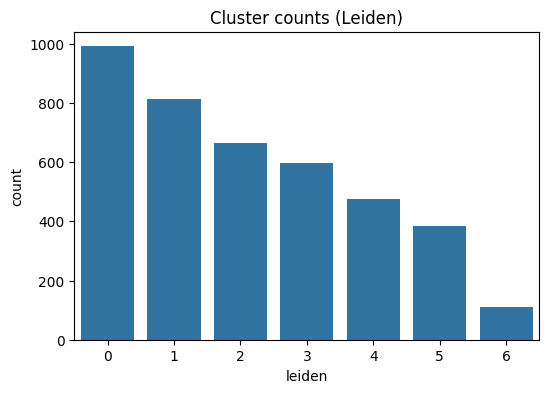

In [25]:
# ========================
# Step 7. Seaborn cluster size plot
# ========================
plt.figure(figsize=(6,4))
sns.countplot(x="leiden", data=adata.obs)
plt.title("Cluster counts (Leiden)")
plt.savefig(os.path.join(out_dir, "cluster_counts.png"))
plt.show()